In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from scipy import stats
#from itertools import compress
from pyBedGraph import BedGraph
from pybedtools import BedTool
import itertools
from collections import Counter

In [2]:
def read_background_rate(directory, background_rate_file):
    tlist = []
    with open(directory + background_rate_file) as f:
        next(f)
        for line in f:
            tmp = line.strip().split("\t")
            tmp[4] = tmp[4].strip('"')
            #tmp[4] = tmp[4][1:-1]
            #for i in [2,3,5]:
                #tmp[i] = int(tmp[i])
            tlist.append([tmp[0], tmp[4], int(tmp[5]), tmp[6]])
    return tlist

In [3]:
def read_motif_rate(directory, motif_rate_file):
    tlist = []
    with open(directory + motif_rate_file) as f:
        next(f)
        for line in f:
            tmp = line.strip().split("\t")
            tmp[1] = tmp[1].strip('"')
            left = tmp[1].split(":")[1].split(',')[0]
            ldist = int(left.split('-')[1]) - int(left.split('-')[0])
            tmp[7] = tmp[7].strip('"')
            right = tmp[7].split(":")[1].split(',')[0]
            rdist = int(right.split('-')[1]) - int(right.split('-')[0])
            tlist.append([tmp[0], tmp[1][-1], tmp[2], ldist, tmp[7][-1], tmp[8], rdist, int(tmp[13]), tmp[14]])
    return tlist

In [4]:
def plot_hist(data, binr, tit, xlab, fig_name):
    """
    Plot histogram.
    """
    plt.hist(data, bins=binr)
    plt.title(tit)
    plt.xlabel(xlab)
    plt.ylabel("Frequency")
    plt.show()
    #plt.savefig(fig_name+'.pdf', dpi=300)
    plt.close()

In [5]:
def plot_scatt(x, y, tit, xlab, ylab, fig_name):
    """
    Plot scatterplot.
    """
    plt.scatter(x, y)
    plt.title(tit)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()
    #plt.savefig(fig_name+'.pdf', dpi=300)
    plt.close()

In [6]:
def categorize_motifrate_L2R(motifrate_list):
    tanmotif = []
    convmotif = []
    tanmotif_smt = []
    convmotif_smt = []
    for x in motifrate_list:
        if x[4] == '+': # tandem
            if x[5][:3] == 'smt' and int(x[5][-1]) > 1: # super motif
                tanmotif_smt.append(x[7] * 8019/x[6])
            else: # simple motif
                tanmotif.append(x[7] * 8019/x[6])
        else: #convergent
            if x[5][:3] == 'smt' and int(x[5][-1]) > 1: # super motif
                convmotif_smt.append(x[7] * 8019/x[6])
            else: # simple motif
                convmotif.append(x[7] * 8019/x[6])
    return tanmotif, convmotif, tanmotif_smt, convmotif_smt

In [7]:
def categorize_motifrate_R2L(motifrate_list):
    tanmotif = []
    convmotif = []
    tanmotif_smt = []
    convmotif_smt = []
    for x in motifrate_list:
        if x[1] == '-': # tandem
            if x[2][:3] == 'smt' and int(x[2][-1]) > 1: # super motif
                tanmotif_smt.append(x[7] * 8019/x[3])
            else: # simple motif
                tanmotif.append(x[7] * 8019/x[3])
        else: #convergent
            if x[2][:3] == 'smt' and int(x[2][-1]) > 1: # super motif
                convmotif_smt.append(x[7] * 8019/x[3])
            else: # simple motif
                convmotif.append(x[7] * 8019/x[3])
    return tanmotif, convmotif, tanmotif_smt, convmotif_smt

In [8]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (8,6))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        median = str(round(np.median(d), 2))
        mean = str(round(np.mean(d), 2))
        dlabel[i] = dlabel[i] + "\n" + str(len(d))+ "\n" + median + "\n" + mean
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    plt.title(tit + "\n" + "recorded n (sample size), median, mean", fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.savefig(fig_name+'.png', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [10]:
directory = '/Users/kimm/Desktop/GM12878_results_20200423/Basic_stats/GM12878-cohesin-pooled_comp_FDR_0.2_PASS_motifext4kbboth_domains/'
backgroundrate_file = 'GM12878-cohesin-pooled_comp_FDR_0.2_PASS_motifext4kbboth_domains_Background_rate.txt'
motifrate_file = 'GM12878-cohesin-pooled_comp_FDR_0.2_PASS_motifext4kbboth_domains_Motif_rate.txt'
data_name = 'GM12878-cohesin-pooled_comp_FDR_0.2_PASS'

In [11]:
motifrate = read_motif_rate(directory, motifrate_file)

In [12]:
boundaries = [key for key, val in Counter([','.join([x[2], x[5]]) for x in motifrate]).items() if val == 2]

In [13]:
motifrate_L2R = [x for x in motifrate if x[8] == 'L2R' and ','.join([x[2], x[5]]) not in boundaries]
motifrate_R2L = [x for x in motifrate if x[8] == 'R2L' and ','.join([x[2], x[5]]) not in boundaries]

In [14]:
backgroundrate = read_background_rate(directory, backgroundrate_file)

In [15]:
nomotif_L2R = [x[2] for x in backgroundrate if x[1] == '.' and x[3] == 'L2R']
nomotif_R2L = [x[2] for x in backgroundrate if x[1] == '.' and x[3] == 'R2L']

In [16]:
tanmotif_L2R, convmotif_L2R, tanmotif_L2R_smt, convmotif_L2R_smt = categorize_motifrate_L2R(motifrate_L2R)

In [17]:
tanmotif_R2L, convmotif_R2L, tanmotif_R2L_smt, convmotif_R2L_smt = categorize_motifrate_R2L(motifrate_R2L)

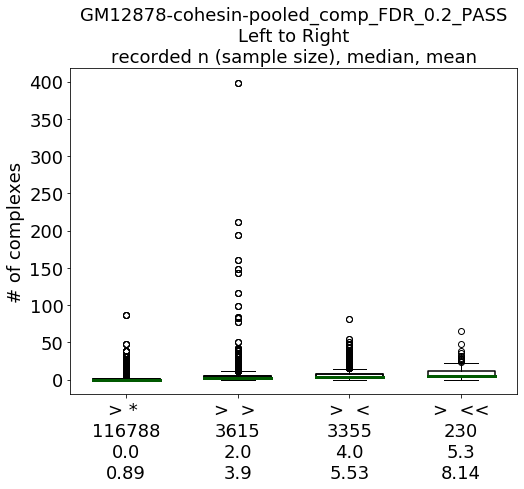

In [19]:
plot_boxplot([nomotif_L2R, tanmotif_L2R,  convmotif_L2R, convmotif_L2R_smt], ['> * ', '>  > ', '>  <', '>  <<'], '#005900', data_name+ "\n" + 'Left to Right', '# of complexes', "slope_boxplot_" + data_name+"_L2R_raw_v2")

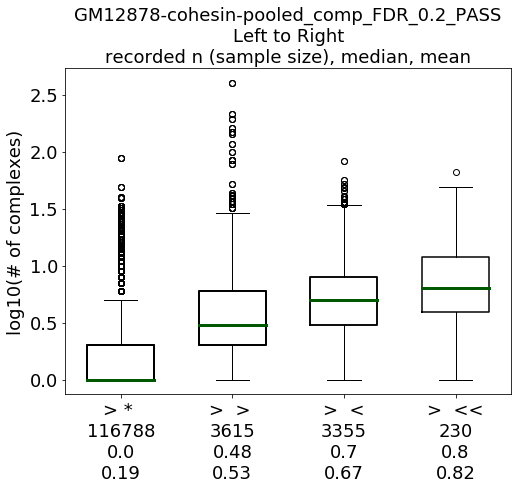

In [20]:
plot_boxplot([[np.log10(x+1) for x in nomotif_L2R], [np.log10(x+1) for x in tanmotif_L2R], [np.log10(x+1) for x in convmotif_L2R], [np.log10(x+1) for x in convmotif_L2R_smt]], ['> * ', '>  > ',  '>  <', '>  <<'], '#005900',  data_name+ "\n" + 'Left to Right', 'log10(# of complexes)', "slope_boxplot_" + data_name+"_L2R_log_v2")